# NBA referees analysis: endgame accuracy

This notebook provides analysis of the accuracy of NBA referees with respect to whether a call is correct or not in the last 2 minutes of a game. This notebook was inspired by Austin Rochford's [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html). Our main aim is to quantify a latent variable, an experience-indicator of the performace of referees. This can be an important indicator for league managers. An indicator of variance could be particularly useful as the mean correct calls can be very similar for several referees, but at the same time a small variance is... Comment on game more delicate..

The analysis is carried out with three Bayesian models: 
- a vanilla beta-Bernoulli model, 
- a hiherchical beta-Bernoulli model,
- a hiherchical log-odds ratio.

For the latter two the hierarchy is introduced by classifying referees with respect to three experience levels, namely less than 10 years, between 10 and 20 and more than 20 years of refereeing NBA games. 

The main conlclusion is that there is a significant difference in precision between referees with less than 10 years experience and more than 10 years experience.


## Research questions
- Which referees are more likely to make a correct call in the last two minutes of the game? 
- What is the impact of referee's experience in making a correct call?
- What is a good classification of experience to classify engame precision?

[Data set](https://github.com/polygraph-cool/last-two-minute-report) derived from the NBA's [Last Two Minute Report](http://official.nba.com/nba-last-two-minute-reports-archive/) by [Russell Goldenberg](http://russellgoldenberg.com/) of [The Pudding](https://pudding.cool/). NBA referee list can be found here: https://www.basketball-reference.com/referees/.

## Comments on data issues
- Lack of data on the referee that made the call.
- Referees selection.
- Other variables that might be taken into account...

## Data collection and cleaning
We first import the data:

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
plt.style.use('seaborn')
%matplotlib inline

In [4]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

In [5]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    index_col='play_id',
    parse_dates=['date']
)

In [6]:
#orig_df.to_csv('file.csv')
USECOLS = [
    'period',
    'seconds_left',
    'call_type',
    'committing_player',
    'disadvantaged_player',
    'review_decision',
    'away',
    'home',
    'ref_1',
    'date',
    'score_away',
    'score_home',
    'disadvantaged_team',
    'committing_team'
]
df = orig_df[USECOLS].dropna(axis=0)

We add three colunms: season,  referee id, referee experience.

In [7]:
########################
#Add season column

def date_to_season(date):
    if date >= datetime.datetime(2017, 10, 17):
        return '2017-2018'
    elif date >= datetime.datetime(2016, 10, 25):
        return '2016-2017'
    elif date >= datetime.datetime(2015, 10, 27):
        return '2015-2016'
    else:
        return '2014-2015'
df = df.assign(season=lambda df: df['date'].apply(date_to_season))

########################
#Add referee ID

ref_lis = list(set(df.ref_1))
ref_lis.sort()
years_exp = []
for ref in ref_lis:
    ID = ref.split(' ')[1:][0][0:5] +ref[0:2]+'99r'
    #print(ID)
    try:
      df_re = pd.read_html(f'https://www.basketball-reference.com/referees/{ID.lower()}.html')
      #print(df_re)
      first, last = df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[0,:][0], df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[-2,:][0]
      first, last = int(first[0:4]), int(last[0:4])
      #print(last-first)
      years_exp.append(last-first)
    except:
      print(f'Url not found for {ref}.')
      years_exp.append('NAN')
        
def ref_exper(ref):
    idx = ref_lis.index(ref)
    return years_exp[idx]

df = df.assign(ref_exp=lambda df: df['ref_1'].apply(ref_exper))

########################
#Add referee experience (Junior = 10, Mid = 20, Senior = 30)

def exp_year_cls(ref_exp):
    try: 
       ref_exp = int(ref_exp) 
       if ref_exp >= 20:
        return 20
       elif ref_exp >= 10:
        return 10
       elif ref_exp >= 0:
        return 0   
    except:
        return 0 # None
        
df = df.assign(ref_exp_cls=lambda df: df['ref_exp'].apply(exp_year_cls))
#df.ref_exp.value_counts()

Url not found for J.T. Orr.


In [8]:
df['review_decision'].value_counts().head(n=15)

CNC    8129
CC     4016
INC     981
IC      151
Name: review_decision, dtype: int64

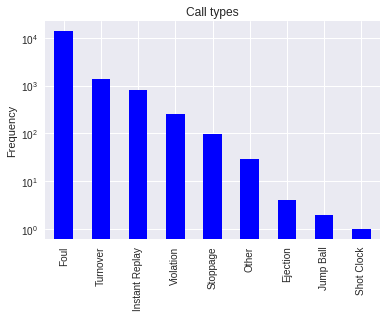

In [300]:
(orig_df['call_type']
        .str.split(':', expand=True)
        .iloc[:, 0]
        .value_counts()
        .plot(
            kind='bar',
            color='blue', logy=True, 
            title="Call types"
        )
        .set_ylabel("Frequency"));

In [10]:
df_ref_c = df.loc[:,['seconds_left','call_type','review_decision','ref_1','ref_exp_cls']]
df_ref_c = df_ref_c.loc[(df_ref_c.review_decision == 'CC')|(df_ref_c.review_decision == 'IC')].loc[df_ref_c.seconds_left<=120]

In [13]:
def call_to_binary(review_decision):
    out = 0
    if review_decision == 'CC':
        out = 1
    return out
df_ref_c = df_ref_c.assign(review_decision_bin=lambda df_ref_c: df_ref_c['review_decision'].apply(call_to_binary))

In [14]:
ref_num = len(set(df_ref_c.ref_1))
ref_list = list(set(df_ref_c.ref_1))
ref_list.sort()
def ref_to_index(ref_1):
    return ref_list.index(ref_1)

df_ref_c = df_ref_c.assign(ref_1_idx=lambda df_ref_c: df_ref_c['ref_1'].apply(ref_to_index))
df_ref_c.head()
#remove referees with less than 50 calls.
#df_ref_c.ref_1.value_counts()
#df_ref_c.groupby('ref_1').filter(lambda x : len(x)>39).ref_1.value_counts()
df_ref_c = df_ref_c[df_ref_c.ref_exp_cls != 'NAN']
#set(df_ref_c.ref_exp_cls)

In [15]:
#df_ref_c.ref_exp_cls.value_counts()
#df_ref_c.loc[df_ref_c['ref_1'].value_counts()>49]
#(df_ref_c['ref_1'].value_counts()>49) | (df_ref_c['ref_exp_cls']>0)
#d_temp = df_ref_c[df_ref_c.ref_1 in (df_ref_c['ref_1'].value_counts()>49)]

Text(0.5, 1.0, 'Number of Correct and Incorrect calls')

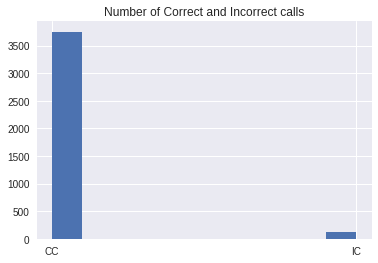

In [301]:
df_ref_c.review_decision.hist()
plt.title('Number of Correct and Incorrect calls')

Text(0.5, 1.0, 'Correct/Incorrect Calls according to seconds left')

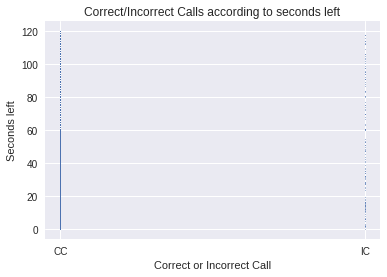

In [303]:

#df_ref_c.seconds_left.hist()
plt.plot(df_ref_c.review_decision, df_ref_c.seconds_left, 'o', markersize=.6)
plt.xlabel('Correct or Incorrect Call')
plt.ylabel('Seconds left')
plt.title('Correct/Incorrect Calls according to seconds left')

## Beta-Bernoulli model
Denote by $n+1$ the number of plays with Foul calls,  $c$ the number of correct foul calls, by $R+1$ the number of referees. Indexing referees by $k=0,1,..,R$, we denote by $n_k$ the number of calls made made by referee $k$ and by $c_k$ the number of correct calls made by referee $k$. Let's study a simple Bernoulli trials model to estimate the probability $p_{k}$ where $k$ is a (leading) referee and $k(i)$ is the referee for the call $i$. The likelihood of (each realisation of) the model is
$$
y_i \sim p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]},
$$
and the prior on each $p_{k}$ is $Beta(\alpha,\beta)$ distributed, so that our model is
$$
p(\theta|y)\propto p(y|\theta)p(\theta) =\Big(\prod_{i=0}^n p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]}\Big)\prod_{j=0}^R \binom{n_j}{c_j}\frac{p_{j}^{\alpha-1}(1-p_{j})^{\beta-1}}{B(\alpha, \beta)}.
$$

In [16]:
import pymc3 as pm
import arviz as az

In [17]:
ref_num = len(set(df.ref_1))
idx = df_ref_c.ref_1_idx
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern:
    #Prior
    p = pm.Beta('p', alpha =1,beta=1, shape=ref_num)    
    #Likelihood
    y = pm.Bernoulli('y',  p[idx], observed = observed_calls)
    

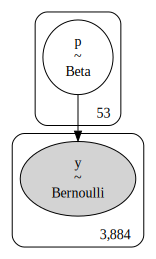

In [18]:
pm.model_to_graphviz(mod_bern)

In [328]:
n_tune = 1000
n_samples = 1000
seed = 2398572
chains =4
def sample(model, n_tune, n_samples, seed, chains):
    with model:
        full_trace = pm.sample(n_tune + n_samples, tune=n_tune, chains=chains, cores=chains, random_seed=seed, return_inferencedata=True, target_accept=.8)
        
    return full_trace#full_trace[n_tune:]

In [29]:
trace_bern = sample(mod_bern, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [p]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.


By plotting the trace we can see quite different performances in making a correct call between different referees.

In [48]:
def energy_plot(trace):
    energy = trace.sample_stats.energy[0]
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

In [ ]:
energy_plot(trace_bern)

In [ ]:
az.plot_trace(trace_bern) 
az.plot_forest(trace_bern) #ref_val = .9
az.plot_posterior(trace_bern, ref_val=.95 )#ax=ax[k, l]
    

In [ ]:
trace_bern

In [30]:
with mod_bern:
    prior_checks = pm.sample_prior_predictive(samples=1000)
    ppc = pm.sample_posterior_predictive(trace_bern, samples=500)


/home/mas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Hierarchical beta-Bernoulli

In [38]:
idx = df_ref_c.ref_1_idx
idx_al_be = []
for j in range(len(set(idx))):
    try:
     idx_al_be.append(int(list(set(df_ref_c.ref_exp_cls.loc[df_ref_c.ref_1_idx == j].values))[0]/10))
    except:
        print(j)
        pass
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern_hier:
    #Hyperprior
    alpha = pm.Uniform('alpha', lower=0, upper=20, shape =3)
    beta = pm.Uniform('beta', lower=0, upper=20, shape =3)
    #Prior
    p = pm.Beta('p', alpha=alpha[idx_al_be], beta=beta[idx_al_be], shape=len(set(idx)))
    #Likelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

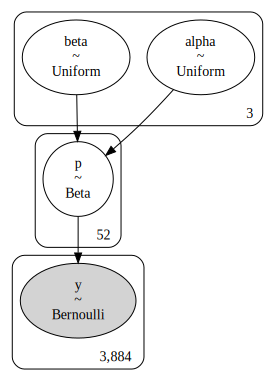

In [39]:
pm.model_to_graphviz(mod_bern_hier)

In [40]:
trace_bern_hier = sample(mod_bern_hier, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [p, beta, alpha]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [52]:
trace_bern_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

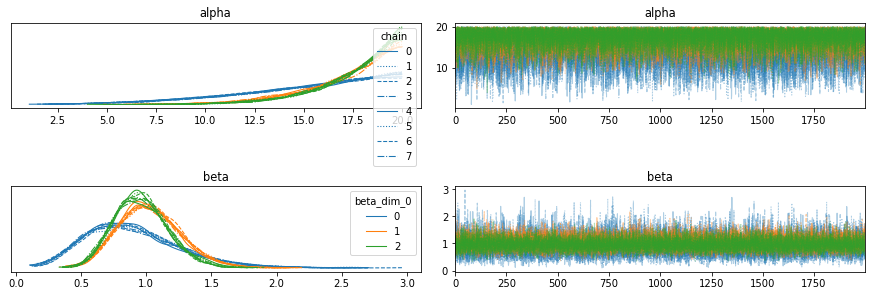

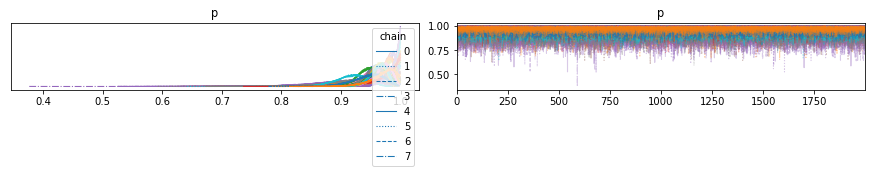

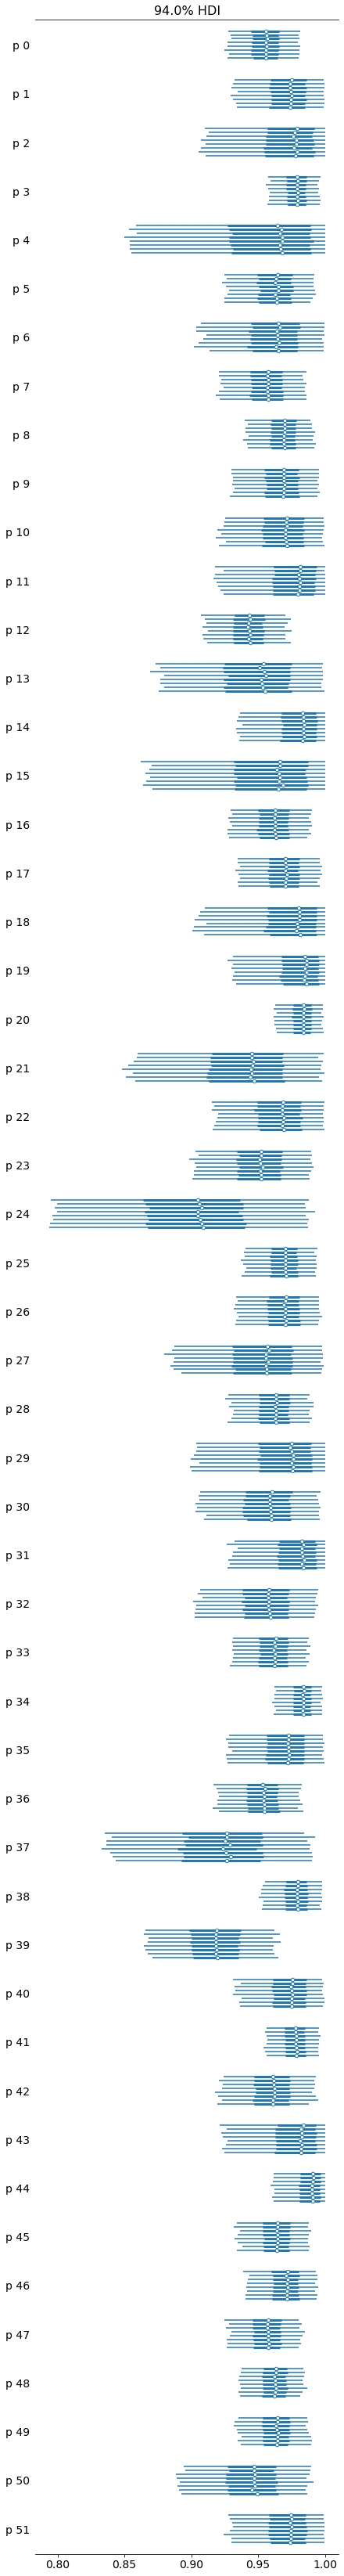

In [45]:
az.plot_trace(trace_bern_hier.posterior[['alpha','beta']], legend=True) 
az.plot_trace(trace_bern_hier.posterior['p'],legend=True) 
az.plot_forest(trace_bern_hier.posterior['p']) 

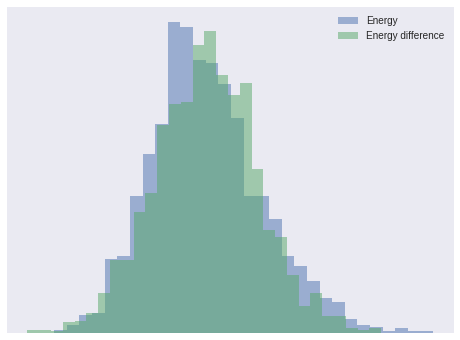

In [304]:
energy_plot(trace_bern_hier)

In [ ]:
trace_bern_hier.posterior[['alpha','beta']]

Recall that the averate of a beta stable distribution is $\alpha/(\alpha+\beta)$ and the variance is $\alpha\beta/((\alpha+\beta)^2(\alpha+\beta+1))$. So we sample from the the posterior distribution of $\alpha$ and $\beta$ to estimate the mean and variance.


In [81]:
with mod_bern_hier:
    prior_checks_bern_hier = pm.sample_prior_predictive(samples=1000)
    #ppc_bern_hier = pm.sample_posterior_predictive(trace_bern_hier, samples=500, random_seed=seed)
    ppc_bern_hier_alp = pm.sample_posterior_predictive(trace_bern_hier, var_names=['alpha'], samples=500, random_seed=seed)
    ppc_bern_hier_beta = pm.sample_posterior_predictive(trace_bern_hier, var_names=['beta'], samples=500, random_seed=seed)


/home/mas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [255]:
'''
s=40
np.linspace(0,20,s)
list_ = [sum(1 for x in ppc_bern_hier_alp['alpha'][:,0] if x >= j and  x < j+1/s) for j in np.linspace(0,20,s)]
plt.plot(np.linspace(0,20,s),list_)
list_
np.linspace(0,20,s)
sum(1 for x in ppc_bern_hier_alp['alpha'][:,0] if x >= 18)
'''
means, var = [], []
for i in range(len(ppc_bern_hier_alp['alpha'][0,:])):
    m = ppc_bern_hier_alp['alpha'][:,i]/(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])
    v = (ppc_bern_hier_alp['alpha'][:,i]*ppc_bern_hier_beta['beta'][:,i])/(((ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])**2)*(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i] +1))
    means.append(m.mean())
    var.append(v.mean())

In [256]:
print('Under hierarchical beta-Bernoulli model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical beta-Bernoulli model:
Means of Junior, Mid and Seniors: [0.9436868560569431, 0.9436661715511956, 0.9484424760330041]
Stds of Junior, Mid and Seniors: [0.003558288299139561, 0.002803337399566031, 0.0025188704277961022]


Note that the variance of the beta distribution for:
- a Senior referee is 27% higher than a Junior referee. 
- a Mid referee is 42% higher than a Junor referee.
- a Mid referee is 12% higher than a Senior referee.

Meanwhile the means are negligibly close.

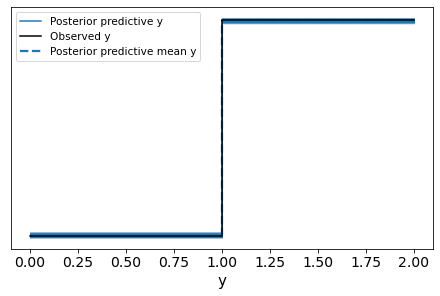

In [76]:
ppc_bern_hier.keys()
#plt.plot(ppc_bern_hier_alp['alpha'])
#ppc_bern_hier_alp['alpha'].shape
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_bern_hier, model=mod_bern_hier));

## Hierarchical logit
We now assume that the log-odds-ratio of $p_k$ is normal distributed as $\eta_k $, with two options below. Recall this model is equivalent to 
$$
p_k = \text{sigmoid}(-\eta_k)=\frac{1}{1+e^{-\eta_k}}.
$$
Version 1: 
$$
\eta_k\sim N(\mu,\sigma), \quad\text{with hyperpriors}\quad \mu\sim N(0,1),\,\sigma\sim \text{HalfCauchy}(1)
$$and we place hyper parameters on $\mu$ and $\sigma$ accordin to our trhee classifications of experience.

In [381]:
import theano.tensor as tt
with pm.Model() as log_norm_hier:
    eta = pm.Normal('eta', mu= 1,sigma=1 ,shape=3)
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta[idx_al_be])) #
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)
    '''
    mu = pm.Normal('mu', mu=3.34, sigma=1, shape=3)
    sigma = np.ones(3)#pm.Uniform('sigma',0,10,shape=3) #pm.HalfNormal('sigma', sigma=.1, shape=3)  very bad #np.ones(3)
    eta = pm.Normal('eta', mu= mu[idx_al_be],sigma=sigma[idx_al_be] ,shape=ref_num-1)
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta)) #
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)
    '''

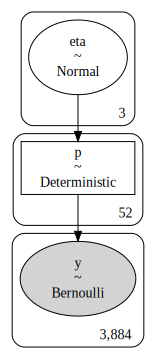

In [382]:
pm.model_to_graphviz(log_norm_hier)

In [383]:
trace_log_norm_hier = sample(log_norm_hier, 4000, n_samples, seed, chains) #n_tune

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 22 seconds.


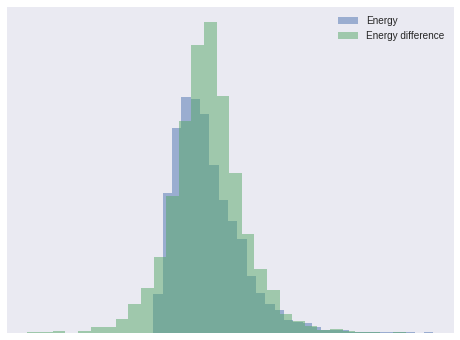

In [384]:
energy_plot(trace_log_norm_hier)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

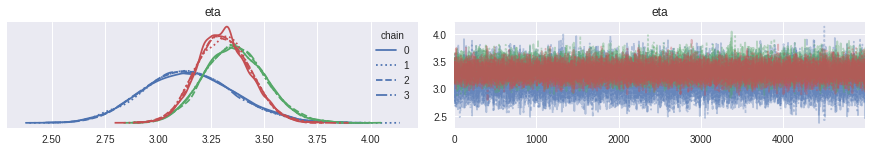

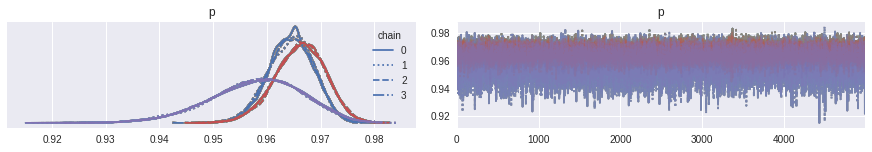

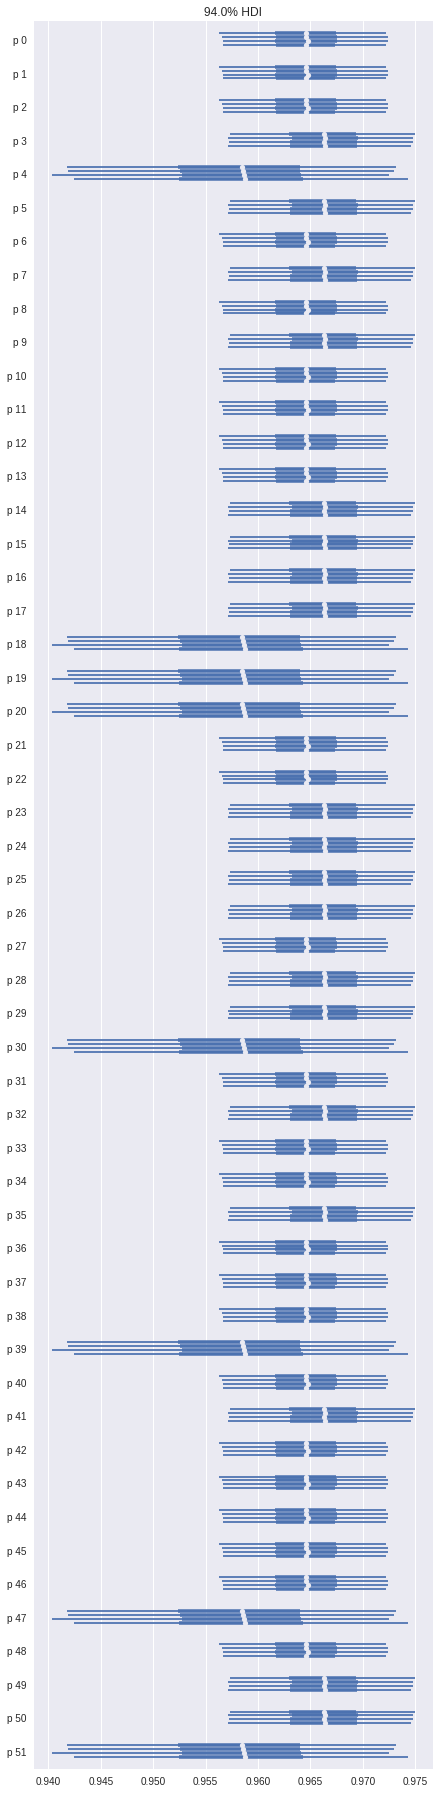

In [385]:
az.plot_trace(trace_log_norm_hier.posterior[['eta']], legend=True)
az.plot_trace(trace_log_norm_hier.posterior['p'],legend=True) 
az.plot_forest(trace_log_norm_hier.posterior['p']) 

/home/mas/anaconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_posterior, generating only 40 plots
  warnings.warn(


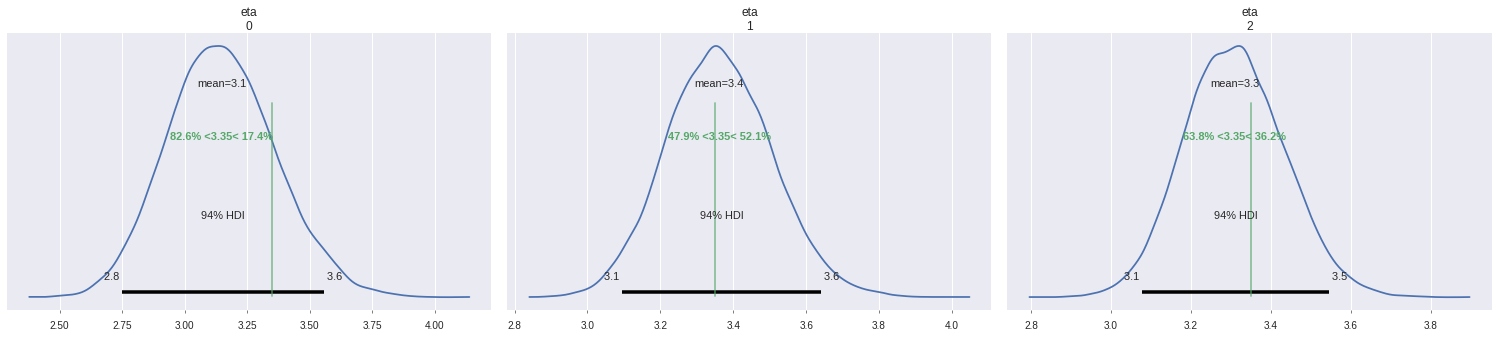

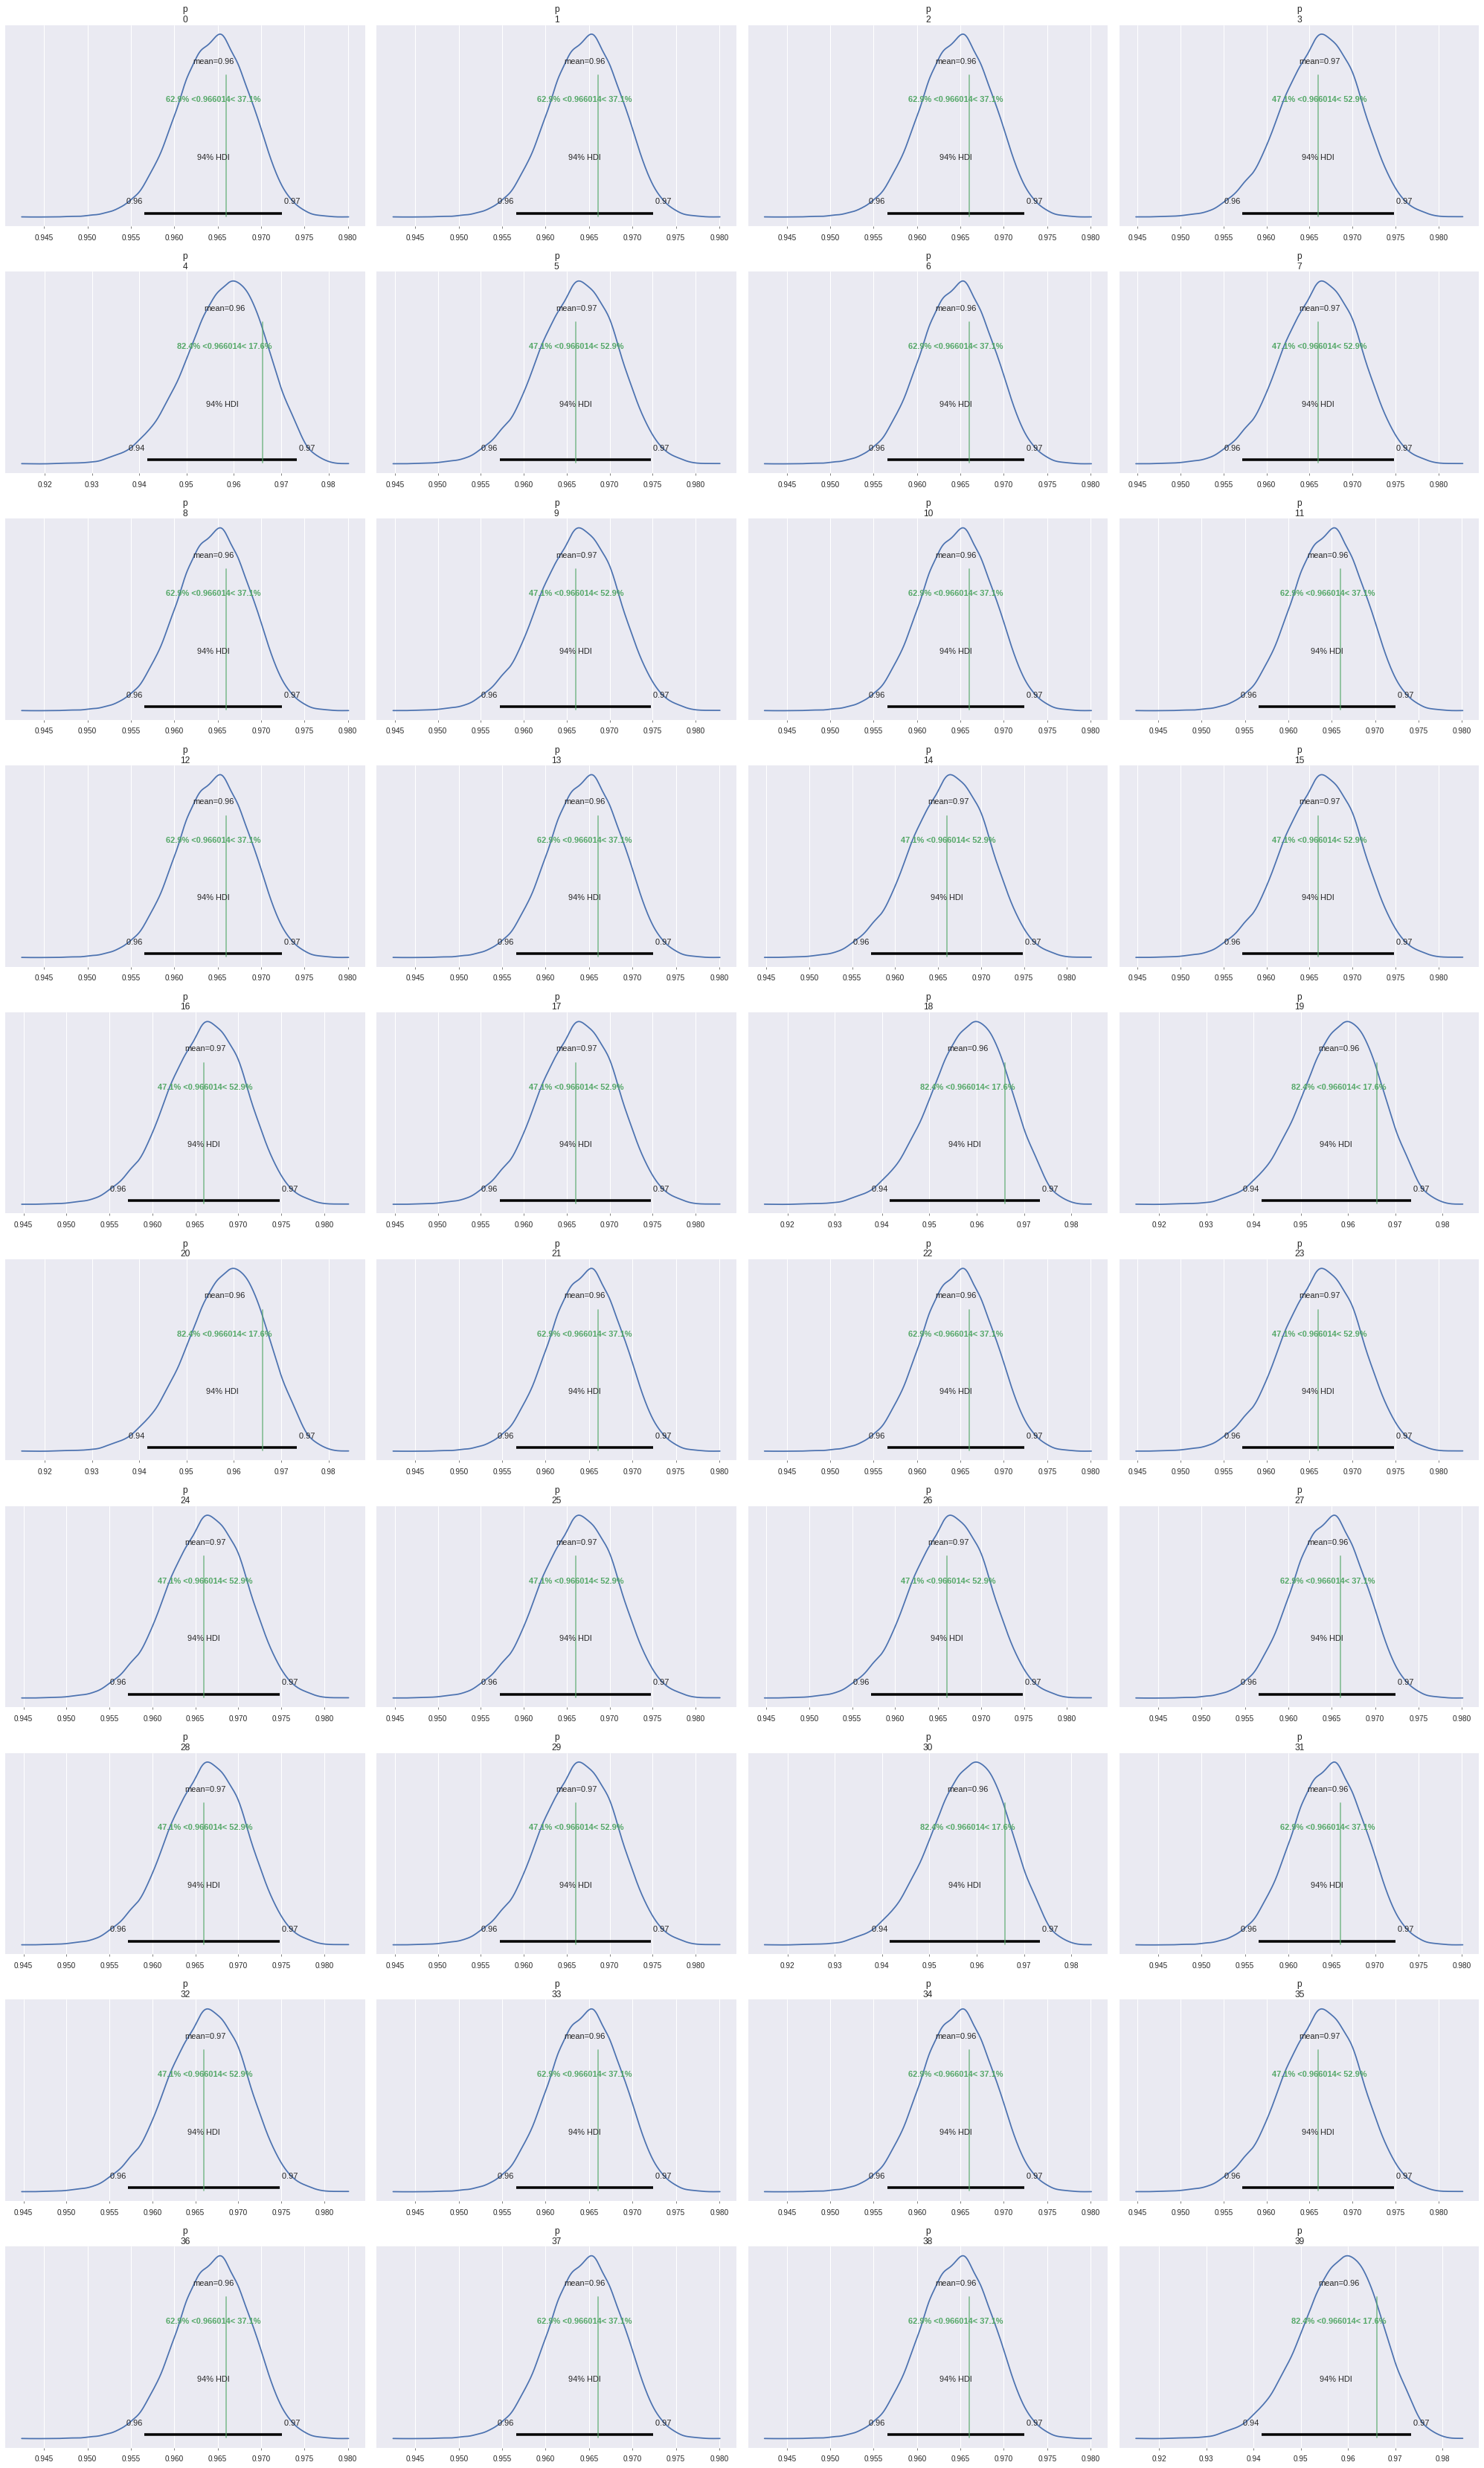

In [386]:
mu_cc = df_ref_c.review_decision_bin.value_counts()[1]/len(df_ref_c.review_decision_bin)
#plt.tight_layout()
pm.plot_posterior(trace_log_norm_hier, ['eta'], ref_val = round(np.log(mu_cc/(1-mu_cc)),2))
#pm.plot_posterior(trace_log_norm_hier, ['sigma'])
ax = pm.plot_posterior(trace_log_norm_hier, ['p'], ref_val = mu_cc);

### Posterior checks
We generate posterior predictive on behaviour of J,M,S etc and compare to previous one.


In [387]:
with log_norm_hier:
    ppc_log_norm_hier_eta = (pm.sample_posterior_predictive(trace_log_norm_hier, var_names=['eta'],
                                                           samples=chains*(4000+n_samples), random_seed=seed))

In [389]:
means, var = [], []
for i in range(len(ppc_log_norm_hier_eta['eta'][0,:])):
    p_ = 1/(1+np.exp(-ppc_log_norm_hier_eta['eta'][:,i]))
    means.append(p_.mean())
    var.append(p_.std())

In [390]:
print('Under hierarchical logit model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical logit model:
Means of Junior, Mid and Seniors: [0.9580258160468976, 0.9661521184394162, 0.964489734817464]
Stds of Junior, Mid and Seniors: [0.008557683430149374, 0.004714964705632115, 0.0042633753130171675]


0.9621928166351607 0.9678082191780822 0.9656992084432717
(529,) (1460,) (1895,)


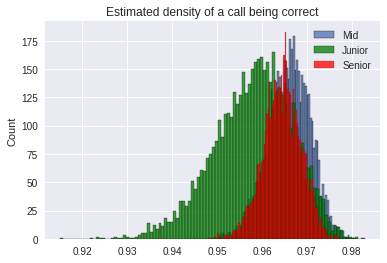

<AxesSubplot:xlabel='p', ylabel='Density'>

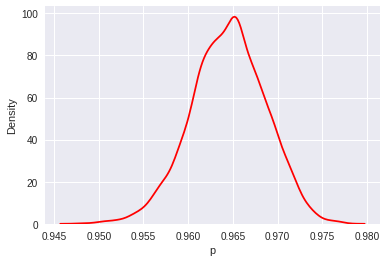

In [474]:
print(df_ref_c.loc[df_ref_c.ref_exp_cls == 0].review_decision_bin.value_counts(1)[1],
      df_ref_c.loc[df_ref_c.ref_exp_cls == 10].review_decision_bin.value_counts(1)[1],
      df_ref_c.loc[df_ref_c.ref_exp_cls == 20].review_decision_bin.value_counts(1)[1]) 
print(df_ref_c.loc[df_ref_c.ref_exp_cls == 0].review_decision_bin.shape,
      df_ref_c.loc[df_ref_c.ref_exp_cls == 10].review_decision_bin.shape,
      df_ref_c.loc[df_ref_c.ref_exp_cls == 20].review_decision_bin.shape)
#pm.plot_trace(trace_log_norm_hier)
'''
fig, ax = plt.subplots(1,1)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,20],bins=100)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,3],bins=100)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,0],bins=100)
plt.show()
'''

import seaborn as sns
#sns.kdeplot(trace_log_norm_hier.posterior['p'][0,:,3] , bw_method = 1 , fill = True)
fig,ax = plt.subplots()
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,3], ax =ax,bins=100, label='Mid')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,20], ax =ax, color ='green',bins=100, label='Junior')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,0], ax =ax, color ='red', bins=100, label='Senior')
ax.set_title('Estimated density of a call being correct')
ax.legend()
plt.show()
sns.kdeplot(trace_log_norm_hier.posterior['p'][0,:,0],  color ='red')
#set(df_ref_c.loc[df_ref_c.ref_exp_cls == 20].ref_1_idx)

## Age selection logit model
$$
p_k = \text{sigmoid}(-\eta_k)=\frac{1}{1+e^{-\eta_k}}.
$$
Version 2: 
$$
\eta_k\sim N(\mu_k,\sigma_k) +b_0+b_1x_k, \quad\text{with hyperpriors}\quad \mu_k\sim N(0,1),\,\sigma_k\sim \text{HalfCauchy}(1), \,b_0\sim N(0,1),\,b_1\sim N(0,1),
$$
where $X_k$ is the years of experience of a referee.


So the estimated slope $b_1$ is supposed to tell us...

In [ ]:
'''

def seconds_left_to_mins(seconds_left):
    if seconds_left >= 100:
        return 100
    elif seconds_left >= 80:
        return 80
    elif seconds_left >= 60:
        return 60
    elif seconds_left >= 40:
        return 40
    elif seconds_left >= 20:
        return 20
    else:
        return 0
df = df.assign(time_left=lambda df: df['seconds_left'].apply(seconds_left_to_mins))

##########################
'''

Check comments on logit

Collcet highest to lowest variance and check referees
estimate how much variance is dependent on low sample size